## week10: Convolutional neural networks

Inspiration for this notebook is taken from YSDA materials

__Colab is highly recommended to work with this notebook__

### About CNNs
Convolutional layers extract features - quantitative representations of some attributes.

After the extraction you can use these features for classification, for example.

<img src="https://github.com/EvgenVer/ml_course/blob/main/week0_10_cnn/img/act.png?raw=1" width="800">

#### Convolution:
<img src="https://github.com/EvgenVer/ml_course/blob/main/week0_10_cnn/img/convolution.gif?raw=1" width="400">

### Pooling:
<img src="https://github.com/EvgenVer/ml_course/blob/main/week0_10_cnn/img/pooling.gif?raw=1" width="400">


## Deeper layer $\to$ more complex features.

<img src="https://github.com/EvgenVer/ml_course/blob/main/week0_10_cnn/img/feat.png?raw=1" width="800">

# Task: Cats vs. Dogs Classification

<img src="https://github.com/EvgenVer/ml_course/blob/main/week0_10_cnn/img/cat_dog_sota.jpg?raw=1" width="600">




Let's try to build a small convolutional neural network capable of separating cat images from dog images.

## Datasets in pyTorch

Generally, when you have to deal with image, text, audio or video data, you can use standard python packages that load data into a numpy array. Then you can convert this array into a torch.*Tensor.

- For images, packages such as *Pillow*, *OpenCV* are useful
- For audio, packages such as *scipy* and *librosa*
- For text, either raw *Python* or *Cython* based loading, or *NLTK* and *SpaCy* are useful

We are dealing with images, so let's have a look at image data loading in pyTorch for [Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats) classification competition.

The link for data downloading is in the cell below.

Training set size is reduced for performace. If you have enough computational resources, use [this link](https://www.dropbox.com/s/h2vhfxb0j3eazu1/train.zip) for downloading instead of the latter one.

In [1]:
# Training set with 11K images
! wget https://www.dropbox.com/s/gqdo90vhli893e0/data.zip
! unzip -qq data.zip -d data

--2023-09-25 15:43:05--  https://www.dropbox.com/s/gqdo90vhli893e0/data.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/gqdo90vhli893e0/data.zip [following]
--2023-09-25 15:43:06--  https://www.dropbox.com/s/raw/gqdo90vhli893e0/data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc453a1ad362a7d2aa6766b46653.dl.dropboxusercontent.com/cd/0/inline/CEYuEW5u6DCcw8K8KPVOPVFsid6UIGOvOAEPgBS6zY-1sjAVwIsQT681jQoQ9muyxdqZpmHVQL3KCAHZnc9HnDzbJIznlewC-d3QT5NXasA8KvU8wlQ6tSGfCMCLbYqUw3w/file# [following]
--2023-09-25 15:43:06--  https://uc453a1ad362a7d2aa6766b46653.dl.dropboxusercontent.com/cd/0/inline/CEYuEW5u6DCcw8K8KPVOPVFsid6UIGOvOAEPgBS6zY-1sjAVwIsQT681jQoQ9muyxdqZpmHVQL3KCAHZnc9HnDzbJIznlewC-d3QT5NXasA8KvU8wlQ6tSGfCMCLbYqUw3w/fil

Now let's look at the way datasets are processed in PyTorch.

In [29]:
import torch
from torchvision import transforms
from torchsummary import summary
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from matplotlib import pyplot as plt
import numpy as np
import time
from collections import defaultdict
from tqdm.auto import tqdm

import os
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

Images should be stored class-wise in PC memory: each image class have to be represented as a subfolder with the corresponding image data. `ImageFolder` takes the path to 'root' directory of such structure, e.g. DATA_PATH:

- DATA_PATH/dog/xxx.png
- DATA_PATH/dog/xxy.png
- DATA_PATH/dog/xxz.png
- DATA_PATH/cat/123.png
- DATA_PATH/cat/nsdf3.png
- DATA_PATH/cat/asd932_.png

Dataset images are of different size.

Batch generator expects a batch of tensors of the same dimensions, thus we need to rescale images in the dataset during data loading.

Let's see at the image size distributions.

In [30]:
### Let's have a cell with global hyperparameters for the CNNs in this notebook

# Path to a directory with image dataset and subfolders for training, validation and final testing
DATA_PATH = r"data"

# Number of threads for data loader
NUM_WORKERS = 2

# Image size: even though image sizes are bigger than 64, we use this to speed up training
SIZE_H = SIZE_W = 96

# Number of classes in the dataset
NUM_CLASSES = 2

# Epochs: number of passes over the training data, we use it this small to reduce training babysitting time
EPOCH_NUM = 30

# Batch size: for batch gradient descent optimization, usually selected as 2**K elements
BATCH_SIZE = 256

# Images mean and std channelwise
image_mean = [0.485, 0.456, 0.406]
image_std  = [0.229, 0.224, 0.225]

# Last layer (embeddings) size for CNN models
EMBEDDING_SIZE = 128

Let's define a transformer to be used as image preprocessing step prior to creating pyTorch image dataset

In [31]:
transformer = transforms.Compose([
    transforms.Resize((SIZE_H, SIZE_W)),        # scaling images to fixed size
    transforms.ToTensor(),                      # converting to tensors
    transforms.Normalize(image_mean, image_std) # normalize image data per-channel
])

Create an ImageFolder instance to be used during training, validation and testing phases.

In [32]:
# load dataset using torchvision.datasets.ImageFolder
train_dataset = torchvision.datasets.ImageFolder(os.path.join(DATA_PATH, 'train_11k'), transform=transformer)
val_dataset = torchvision.datasets.ImageFolder(os.path.join(DATA_PATH, 'val'), transform=transformer)

In [33]:
# load test data also, to be used for final evaluation
test_dataset = torchvision.datasets.ImageFolder(os.path.join(DATA_PATH, 'test_labeled'), transform=transformer)

Save sample num for further use

In [34]:
n_train, n_val, n_test = len(train_dataset), len(val_dataset), len(test_dataset)
n_train, n_val, n_test

(11250, 2500, 12494)

Now let's create a DataLoader instance, which uses ImageFolder instance to generate batches of data.

In [35]:
train_batch_gen = torch.utils.data.DataLoader(train_dataset,
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              num_workers=NUM_WORKERS)

In [36]:
val_batch_gen = torch.utils.data.DataLoader(val_dataset,
                                            batch_size=BATCH_SIZE,
                                            num_workers=NUM_WORKERS)

In [37]:
test_batch_gen = torch.utils.data.DataLoader(test_dataset,
                                             batch_size=BATCH_SIZE,
                                             num_workers=NUM_WORKERS)

Let's create a helper function to vizualize images from our data loaders (and also make sure data was properly loaded).

In [38]:
def plot_from_batch_generator(batch_gen):
    data_batch, label_batch = next(iter(batch_gen))
    grid_size = (3, 3)
    f, axarr = plt.subplots(*grid_size)
    f.set_size_inches(15,10)
    class_names = batch_gen.dataset.classes
    for i in range(grid_size[0] * grid_size[1]):

        # read images from batch to numpy.ndarray and change axes order [H, W, C] -> [H, W, C]
        batch_image_ndarray = np.transpose(data_batch[i].numpy(), [1, 2, 0])

        # inverse normalization for image data values back to [0,1] and clipping the values for correct pyplot.imshow()
        src = np.clip(image_std * batch_image_ndarray + image_mean, 0, 1)

        # display batch samples with labels
        sample_title = 'Label = %d (%s)' % (label_batch[i], class_names[label_batch[i]])
        axarr[i // grid_size[0], i % grid_size[0]].imshow(src)
        axarr[i // grid_size[0], i % grid_size[0]].set_title(sample_title)
    pass

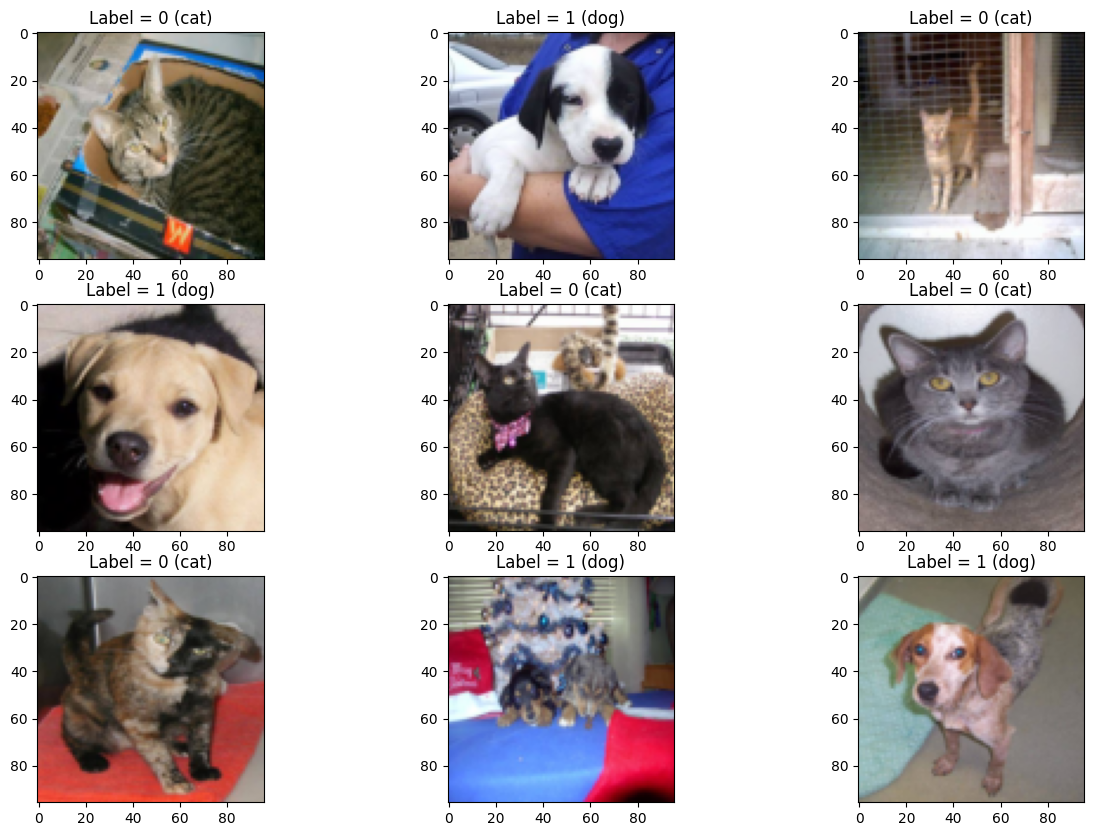

In [39]:
plot_from_batch_generator(train_batch_gen)

# Creating a Training Loop

Many (but not all) of the modern deep learning methods use stochastic gradient descent to update complex model weights so the specified loss function is minimized over the given training dataset. So the actual 'training' process has many common steps that should be applied regardless of the deep learning model type: CNN, RNN, Transformer, BERT, other scary monsters etc.

Let's try to sum up some of those steps in form of a custom `Runner` class.

In fact, we are stealing some of the naming conventions from the [catalyst](https://github.com/catalyst-team/catalyst) Deep Learning library and simplify them so you can understand the basics.

In [40]:
from IPython.display import clear_output

class Runner():
    """Runner for experiments with supervised model."""
    def __init__(self, model, opt, device, checkpoint_name=None):
        self.model = model
        self.opt = opt
        self.device = device
        self.checkpoint_name = checkpoint_name

        self.epoch = 0
        self.output = None
        self.metrics = None
        self._global_step = 0
        self._set_events()
        self._top_val_accuracy = -1
        self.log_dict = {
            "train": [],
            "val": [],
            "test": []
        }

    def _set_events(self):
        """
        Additional method to initialize variables, which may store logging and evaluation info.
        The implementation below is extremely simple and only provided to help monitor performance.
        """
        self._phase_name = ''
        self.events = {
            "train": defaultdict(list),
            "val": defaultdict(list),
            "test": defaultdict(list)
        }

    def _reset_events(self, event_name):
        self.events[event_name] = defaultdict(list)

    def forward(self, img_batch, **kwargs):
        """
        Forward method for your Runner.
        Should not be called directly outside your Runner.
        In simple case, this method should only implement your model forward pass.
        It should also return the model predictions and/or other meta info.

        Args:
            batch (mapping[str, Any]): dictionary with data batches from DataLoader.
            **kwargs: additional parameters to pass to the model.
        """
        logits = self.model(img_batch)
        output = {
            "logits": logits,
        }
        return output

    def run_criterion(self, batch):
        """
        Applies the criterion to the data batch and the model output, saved in self.output.

        Args:
            batch (mapping[str, Any]): dictionary with data batches from DataLoader.
        """
        raise NotImplementedError("To be implemented")

    def output_log(self):
        """
        Output log using the statistics collected in self.events[self._phase_name].
        Implement this method for logging purposes.
        """
        raise NotImplementedError("To be implemented")

    def _run_batch(self, batch):
        """
        Runs batch of data through the model, performing forward pass.
        This implementation performs data passing to necessary device and is adapted to the default pyTorch DataLoader.

        Args:
            batch (mapping[str, Any]): dictionary with data batches from DataLoader.
        """
        # split batch tuple into data batch and label batch
        X_batch, y_batch = batch

        # update the global step in iterations over source data
        self._global_step += len(y_batch)

        # move data to target device
        X_batch = X_batch.to(device)

        # run the batch through the model
        self.output = self.forward(X_batch)

    def _run_epoch(self, loader, train_phase=True, output_log=False, **kwargs):
        """
        Method that runs one epoch of the training process.

        Args:
            loader (DataLoader): data loader to iterate
            train_phase (bool): boolean value to determine if this is the training phase.
                Changes behavior for dropout, batch normalization, etc.
        """
        # Train phase
        # enable or disable dropout / batch_norm training behavior
        self.model.train(train_phase)

        _phase_description = 'Training' if train_phase else 'Evaluation'
        for batch in tqdm(loader, desc=_phase_description, leave=False):

            # forward pass through the model using preset device
            self._run_batch(batch)

            # train on batch: compute loss and gradients
            with torch.set_grad_enabled(train_phase):
                loss = self.run_criterion(batch)

            # compute backward pass if training phase
            # reminder: don't forget the optimizer step and zeroing the grads
            if train_phase:
                loss.backward()
                opt.step()
                opt.zero_grad()

        self.log_dict[self._phase_name].append(np.mean(self.events[self._phase_name]['loss']))

        if output_log:
            self.output_log(**kwargs)

    def train(self, train_loader, val_loader, n_epochs, model=None, opt=None, **kwargs):
        """
        Training process method, that runs for n_epochs over train_loader and performs validation using val_loader.

        Args:
            train_loader (DataLoader): training set data loader to iterate over
            val_loader (DataLoader): validation set data loader to iterate over
            n_epochs (int): epoch number to train for
            model (Model): torch nn.Module or nested class, that implements the model. Overwrites self.model.
            opt (Optimizer): torch optimizer to be used for loss minimization. Overwrites self.opt.
            **kwargs: additional parameters to pass to self.validate.
        """
        self.opt = (opt or self.opt)
        self.model = (model or self.model)

        for _epoch in range(n_epochs):
            start_time = time.time()
            self.epoch += 1
            print(f"epoch {self.epoch:3d}/{n_epochs:3d} started")

            # training part
            self._set_events()
            self._phase_name = 'train'
            self._run_epoch(train_loader, train_phase=True)

            print(f"epoch {self.epoch:3d}/{n_epochs:3d} took {time.time() - start_time:.2f}s")

            # validation part
            self._phase_name = 'val'
            self.validate(val_loader, **kwargs)
            self.save_checkpoint()

    @torch.no_grad() # we do not need to save gradients during validation
    def validate(self, loader, model=None, phase_name='val', **kwargs):
        """
        Validation process method, that estimates the performance of self.model on validation data in loader.

        Args:
            loader (DataLoader): validation set data loader to iterate over
            model (Model): torch nn.Module or nested class, that implements the model. Overwrites self.model.
            opt (Optimizer): torch optimizer to be used for loss minimization. Overwrites self.opt.
            **kwargs: additional parameters to pass to self.validate.
        """
        self._phase_name = phase_name
        self._reset_events(phase_name)
        self._run_epoch(loader, train_phase=False, output_log=True, **kwargs)
        return self.metrics

# Building a network

Simple neural networks with layers applied on top of one another can be implemented as `torch.nn.Sequential` - just add a list of pre-built modules and let it train.

Let's use them to create a baseline for our models.

The following cell implements helper CNN layer.

In [ ]:
# a special module that converts [batch, channel, w, h] to [batch, units]: tf/keras style
# class Flatten(nn.Module):
#     def forward(self, x):
#         # finally we have it in pytorch
#         return torch.flatten(x, start_dim=1)

## Task 0: Multi-layer fully-connected network

Look at the NN structure proposed below.

We will use this model as a baseline for classification task.

As you already know, fully-connetcted networks are not translation invariant and perform worse on image data, so resulting accuracy will be lower than for convolutional neural networks.

In [19]:
model = nn.Sequential()

# reshape from "images" to flat vectors
model.add_module('flatten', nn.Flatten())

# dense "head"
model.add_module('dense1', nn.Linear(3 * SIZE_H * SIZE_W, 256))
model.add_module('dense1_relu', nn.ReLU())
model.add_module('dropout1', nn.Dropout(0.1))
model.add_module('dense3', nn.Linear(256, EMBEDDING_SIZE))
model.add_module('dense3_relu', nn.ReLU())
model.add_module('dropout3', nn.Dropout(0.1))
# logits for NUM_CLASSES=2: cats and dogs
model.add_module('dense4_logits', nn.Linear(EMBEDDING_SIZE, NUM_CLASSES))

Print model summary for sanity check:

In [ ]:
summary(model, (3, SIZE_H, SIZE_W), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                [-1, 27648]               0
            Linear-2                  [-1, 256]       7,078,144
              ReLU-3                  [-1, 256]               0
           Dropout-4                  [-1, 256]               0
            Linear-5                  [-1, 128]          32,896
              ReLU-6                  [-1, 128]               0
           Dropout-7                  [-1, 128]               0
            Linear-8                    [-1, 2]             258
Total params: 7,111,298
Trainable params: 7,111,298
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.11
Forward/backward pass size (MB): 0.22
Params size (MB): 27.13
Estimated Total Size (MB): 27.45
----------------------------------------------------------------


## Construct training pipeline

Now that we can properly load the data and define the NN model structure in terms of input/output, we need to build functions, that will perform forward and backward passes for the model so the backpropagation will optimize the NN weights in accordance with used loss function.

**Question**: What loss funtion do we need to use for the classification task?

In [22]:
# test your loss function calculation
batch_size_test = 8
img = np.random.randint(0, 255, size=(batch_size_test,3, SIZE_H, SIZE_W)).astype(np.float32) / 255
img = (img - np.array(image_mean).reshape(1, 3, 1, 1)) / np.array(image_std).reshape(1,3,1,1)
img_tensor = torch.Tensor(img)
label = torch.Tensor(np.random.randint(0,2, size=batch_size_test)).type(torch.long)

# pass image through model
logits = model(img_tensor)
loss = F.cross_entropy(logits, label)
loss_np = loss.detach().cpu().numpy()

assert loss_np.size == 1, 'compute_loss() shall return a single value of a loss averaged over a batch of samples'

print(f'Loss value: {loss.detach().cpu().numpy()}')

Loss value: 0.6951852440834045


We will also need some training progress monitoring. We would like to calculate classification metrics on the validation set each epoch and plot score distributions for the two classes we have.

All the necessary stuff is implemented in the following cell.
All we need is to create a custom CNNRunner class, where we need to override the class methods `run_criterion` and `output_log`.

**Warning:** Please note, that we will use 'dog class probability' as the CNN score to be used for score distribution plots and classification metrics, as the label of 'dog class' is '1'. In other words, here we will use output neuron 1 and not use output neuron 0.

In [41]:
from sklearn.metrics import f1_score, accuracy_score

class CNNRunner(Runner):
    def run_criterion(self, batch):
        """
        Applies the criterion to the data batch and the model output, saved in self.output.

        Args:
            batch (mapping[str, Any]): dictionary with data batches from DataLoader.
        """
        X_batch, label_batch = batch
        label_batch = label_batch.to(device)

        logit_batch = self.output['logits']

        # compute loss funciton
        loss = F.cross_entropy(logit_batch, label_batch)

        scores = F.softmax(logit_batch, 1).detach().cpu().numpy()[:, 1].tolist()
        labels = label_batch.detach().cpu().numpy().ravel().tolist()

        # log some info
        self.events[self._phase_name]['loss'].append(loss.detach().cpu().numpy())
        self.events[self._phase_name]['scores'].extend(scores)
        self.events[self._phase_name]['labels'].extend(labels)

        return loss

    def save_checkpoint(self):
        val_accuracy = self.metrics['accuracy']
        # save checkpoint of the best model to disk
        if val_accuracy > self._top_val_accuracy and self.checkpoint_name is not None:
            self._top_val_accuracy = val_accuracy
            torch.save(model, open(self.checkpoint_name, 'wb'))

    def output_log(self, **kwargs):
        """
        Output log using the statistics collected in self.events[self._phase_name].
        Let's have a fancy code for classification metrics calculation.
        """
        scores = np.array(self.events[self._phase_name]['scores'])
        labels = np.array(self.events[self._phase_name]['labels'])

        assert len(labels) > 0, print('Label list is empty')
        assert len(scores) > 0, print('Score list is empty')
        assert len(labels) == len(scores), print('Label and score lists are of different size')

        visualize = kwargs.get('visualize', False)
        if visualize:
            clear_output()

        self.metrics = {
            "loss": np.mean(self.events[self._phase_name]['loss']),
            "accuracy": accuracy_score(labels, np.int32(scores > 0.5)),
            "f1": f1_score(labels, np.int32(scores > 0.5))
        }
        print(f'{self._phase_name}: ', end='')
        print(' | '.join([f'{k}: {v:.4f}' for k, v in self.metrics.items()]))

        self.save_checkpoint()

        if visualize:
            # tensorboard for the poor
            fig = plt.figure(figsize=(15,5))
            ax1 = fig.add_subplot(1,2,1)
            ax2 = fig.add_subplot(1,2,2)

            ax1.plot(self.log_dict['train'], color='b', label='train')
            ax1.plot(self.log_dict['val'], color='c', label='val')
            ax1.legend()
            ax1.set_title('Train/val loss.')

            class_0_scores = np.array(scores)[np.array(labels) == 0]
            class_1_scores = np.array(scores)[np.array(labels) == 1]
            ax2.hist(class_0_scores, bins=50, range=[0,1.01], color='r', alpha=0.7, label='cats')
            ax2.hist(class_1_scores, bins=50, range=[0,1.01], color='g', alpha=0.7, label='dogs')
            ax2.legend()
            ax2.set_title('Validation set score distribution.')

            plt.show()

## Training on minibatches

* We got 11k images (22k for full train set), that's way too many for a full-batch SGD. Let's train on minibatches instead
* For visualization purposes we propose to plot train/val loss graphs and validation score distribution for CNN predictions over images of cats (class_0) and dogs (class_1).

In [24]:
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
opt.zero_grad()
ckpt_name = 'model_base.ckpt'
model = model.to(device)

In [25]:
runner = CNNRunner(model, opt, device, ckpt_name)

val: loss: 0.7766 | accuracy: 0.6224 | f1: 0.6318


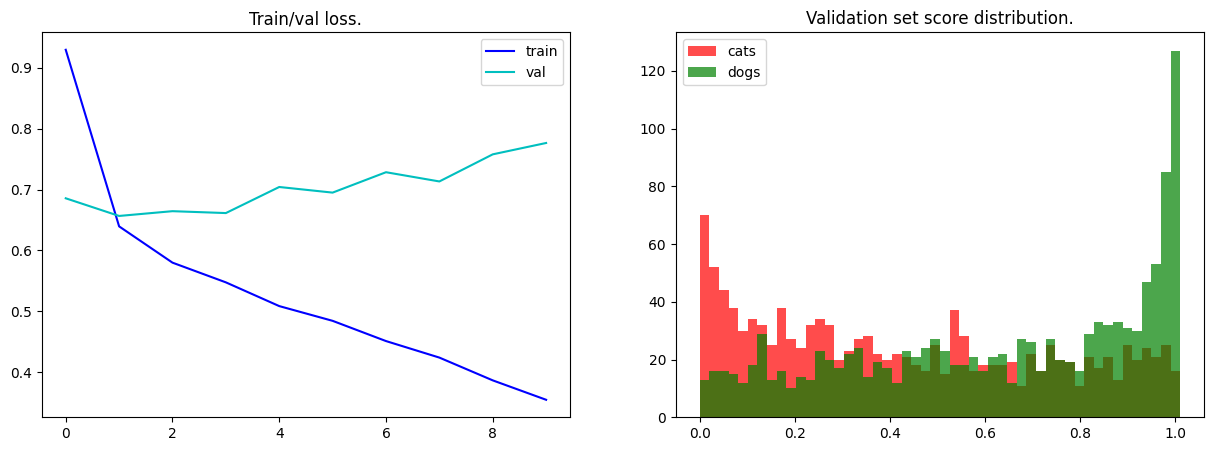

In [26]:
runner.train(train_batch_gen, val_batch_gen, n_epochs=10, visualize=True)

Don't wait for too many epochs. You can interrupt training after 5-15 epochs once validation accuracy stops going up.

**Question:** You might have noticed that training code plots per-class score distribution. How can we use this plot to analyze model performance on binary classification task?
```

```

```

```

```

```

## Evaluate the best model using test set

In [28]:
best_model = None
with open(ckpt_name, 'rb') as f:
    best_model = torch.load(f)

val_stats = runner.validate(val_batch_gen, best_model, phase_name='val')
test_stats = runner.validate(test_batch_gen, best_model, phase_name='test')

if val_stats['f1'] > 0.75 and test_stats['f1'] > 0.75:
    print('You have made fully-connected NN perform surprisingly well, call for the assistant.')
else:
    print('Well done, move on to next block to improve performance.')

Evaluation:   0%|          | 0/10 [00:00<?, ?it/s]

val: loss: 0.7766 | accuracy: 0.6224 | f1: 0.6318


Evaluation:   0%|          | 0/49 [00:00<?, ?it/s]

test: loss: 0.7509 | accuracy: 0.6485 | f1: 0.6562
Well done, move on to next block to improve performance.


# Task I: small convolution net
## First step

**conv-pool-conv-pool-dense-dense-everybody!**

Let's create a mini-convolutional network with roughly such architecture:
* Input layer
* 4 classic convolutional blocks `convolution->relu->pool`:
  * 3x3 convolution with 32 -> 32 -> 64 -> 128 filters and _ReLU_ activation
  * 2x2 pooling (or set previous convolution stride to 3)
 * Flatten
* 30% Dropout
* Dense layer with 128 neurons and _ReLU_ activation
* 30% dropout
* Output dense layer.

__Convolutional layers__ in torch are just like all other layers, but with a specific set of parameters:

__`...`__

__`model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3)) # convolution`__

__`model.add_module('pool1', nn.MaxPool2d(2)) # max pooling 2x2`__

__`...`__


Once you're done (and compute_loss no longer raises errors), train it with __Adam__ optimizer with learning_rate=3e-4 (Karpathy Constant)

If everything is right, you should get at least __75%__ validation accuracy.

__HACK_OF_THE_DAY__ :the number of channels must be in the order of the number of class_labels

__HACK_OF_THE_DAY_2__ : you may set stride=2 for Conv2d layers to increase learning speed, but keep in mind tensor shapes

__HACK_OF_THE_DAY_3__  : it might be useful to use 'VGG-like' structure as a baseline for this task:
    * every CNN layer with 2x2 maxpooling / stride=2 should be followed by increasing the number of output channels x2
    * before the fully-connected layer the tensor H and W should be relatively small (less than 10)
    * in other words, the less H and W of tensor are, the more should you increase C in order to keep more information

In [42]:
model_cnn = nn.Sequential()

# Your code here: CONV->POOL->CONV-POOL->... as many as you wish
# End of your code here
model_cnn.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3))
model_cnn.add_module('ReLU', nn.ReLU())
model_cnn.add_module('pool1', nn.MaxPool2d(2))

model_cnn.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3))
model_cnn.add_module('ReLU', nn.ReLU())
model_cnn.add_module('pool2', nn.MaxPool2d(2))

model_cnn.add_module('conv3', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3))
model_cnn.add_module('ReLU', nn.ReLU())
model_cnn.add_module('pool3', nn.MaxPool2d(2))

model_cnn.add_module('conv4', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3))
model_cnn.add_module('ReLU', nn.ReLU())
model_cnn.add_module('pool4', nn.MaxPool2d(2))

# global average pooling
model_cnn.add_module('global_max_pooling', nn.AdaptiveMaxPool2d(1))
# dropout for regularization
model_cnn.add_module('dropout', nn.Dropout(0.3))
# "flatten" the data
model_cnn.add_module('flat', nn.Flatten())
# last fully-connected layer, used to create embedding vectors
model_cnn.add_module('fc', nn.Linear(128, EMBEDDING_SIZE))
model_cnn.add_module('relu', nn.ReLU())

model_cnn.add_module('dropout_6', nn.Dropout(0.3))

# logits for NUM_CLASSES=2 classes
model_cnn.add_module('fc_logits', nn.Linear(EMBEDDING_SIZE, NUM_CLASSES, bias=False))


__Hint:__ If you don't want to compute shapes by hand, just plug in any shape (e.g. 1 unit) and run compute_loss. You will see something like this:

__`RuntimeError: size mismatch, m1: [5 x 1960], m2: [1 x 64] at /some/long/path/to/torch/operation`__

See the __1960__ there? That's your actual input shape.

Let's see the basic structure of our model and at the same time perform a sanity check for tensor dimensions.

In [43]:
summary(model_cnn, (3, SIZE_H, SIZE_W), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 94, 94]             896
              ReLU-2           [-1, 32, 94, 94]               0
         MaxPool2d-3           [-1, 32, 47, 47]               0
            Conv2d-4           [-1, 32, 45, 45]           9,248
         MaxPool2d-5           [-1, 32, 22, 22]               0
            Conv2d-6           [-1, 64, 20, 20]          18,496
         MaxPool2d-7           [-1, 64, 10, 10]               0
            Conv2d-8            [-1, 128, 8, 8]          73,856
         MaxPool2d-9            [-1, 128, 4, 4]               0
AdaptiveMaxPool2d-10            [-1, 128, 1, 1]               0
          Dropout-11            [-1, 128, 1, 1]               0
          Flatten-12                  [-1, 128]               0
           Linear-13                  [-1, 128]          16,512
             ReLU-14                  [

## Training

We may use the same training pipeline, that we defined above, as it does not depend on model structure.

In [45]:
model_cnn = model_cnn.to(device)
opt = torch.optim.Adam(model_cnn.parameters(), lr=1e-3)
opt.zero_grad()
ckpt_name_cnn='model_cnn.ckpt'
runner_cnn = CNNRunner(model_cnn, opt, device, ckpt_name_cnn)

val: loss: 0.3983 | accuracy: 0.8148 | f1: 0.8143


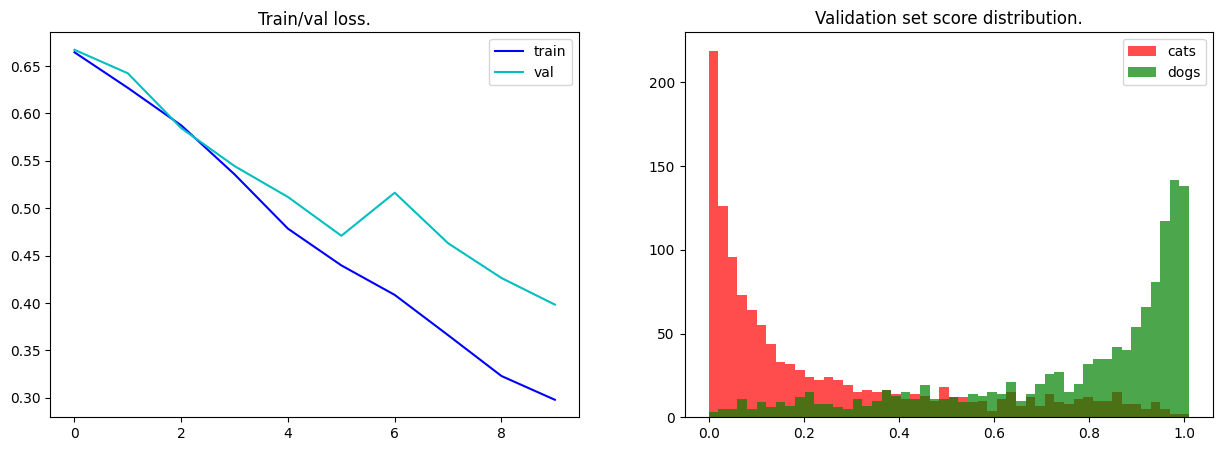

In [46]:
runner_cnn.train(train_batch_gen, val_batch_gen, n_epochs=10, visualize=True)

**A kind reminder again:** don't wait for too many  epochs. You can interrupt training after 5-20 epochs once validation accuracy stops going up.
```
```
## Evaluation


In [47]:
best_model_cnn = None
with open(ckpt_name_cnn, 'rb') as f:
    best_model_cnn = torch.load(f)

val_stats = runner_cnn.validate(val_batch_gen, best_model_cnn, phase_name='val')
test_stats = runner_cnn.validate(test_batch_gen, best_model_cnn, phase_name='test')

if val_stats['f1'] > 0.75 and test_stats['f1'] > 0.75:
    print('You have achieved the baseline for this task.')
else:
    print('Train for some more time.')

Evaluation:   0%|          | 0/10 [00:00<?, ?it/s]

val: loss: 0.3983 | accuracy: 0.8148 | f1: 0.8143


Evaluation:   0%|          | 0/49 [00:00<?, ?it/s]

test: loss: 0.3703 | accuracy: 0.8350 | f1: 0.8349
You have achieved the baseline for this task.


# Task 2: Fine-tuning

## In practice it is easier to use pre-trained NN

<img src="https://github.com/EvgenVer/ml_course/blob/main/week0_10_cnn/img/ft.jpg?raw=1" width="600">

We may see, that our current model performs quite well even after a small number of training epochs.

But for more complicated image classification or other computer vision tasks, it may be difficult to train CNN model from scratch.

State-of-the-art models consist of huge number of layers (100-200 convolutional blocks) and require powerful hardware to converge.

Thankfully, there are lots of pre-trained models available to be used for your own task, only slightly changing some of the final layers to your data.

This is called fine-tuning.

Let's try to load a pre-trained [ResNet-18](https://arxiv.org/abs/1512.03385) model from torch archive and fine-tune its final layers.

### ResNet (Shortcut + Batch Normalization)

<img src="https://github.com/EvgenVer/ml_course/blob/main/week0_10_cnn/img/resnet.png?raw=1" width="800">

In [ ]:
# Load pre-trained model
model_resnet18 = torchvision.models.resnet18(pretrained=True)

# Disable gradient updates for all the layers except  the final layer
# YOUR CODE HERE

# Parameters of newly constructed modules have requires_grad=True by default
num_feat = model_resnet18.fc.in_features

model_resnet18.fc = #YOUR CODE HERE: # add your own prediction part: FC layer for 2 classes

# Use available device for calculations
model_resnet18 = model_resnet18.to(device)

In [ ]:
summary(model_resnet18, (3, SIZE_H, SIZE_W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           9,408
       BatchNorm2d-2           [-1, 64, 48, 48]             128
              ReLU-3           [-1, 64, 48, 48]               0
         MaxPool2d-4           [-1, 64, 24, 24]               0
            Conv2d-5           [-1, 64, 24, 24]          36,864
       BatchNorm2d-6           [-1, 64, 24, 24]             128
              ReLU-7           [-1, 64, 24, 24]               0
            Conv2d-8           [-1, 64, 24, 24]          36,864
       BatchNorm2d-9           [-1, 64, 24, 24]             128
             ReLU-10           [-1, 64, 24, 24]               0
       BasicBlock-11           [-1, 64, 24, 24]               0
           Conv2d-12           [-1, 64, 24, 24]          36,864
      BatchNorm2d-13           [-1, 64, 24, 24]             128
             ReLU-14           [-1, 64,

## Training (only for final layer)

val: loss: 0.3163 | accuracy: 0.8552 | f1: 0.8528


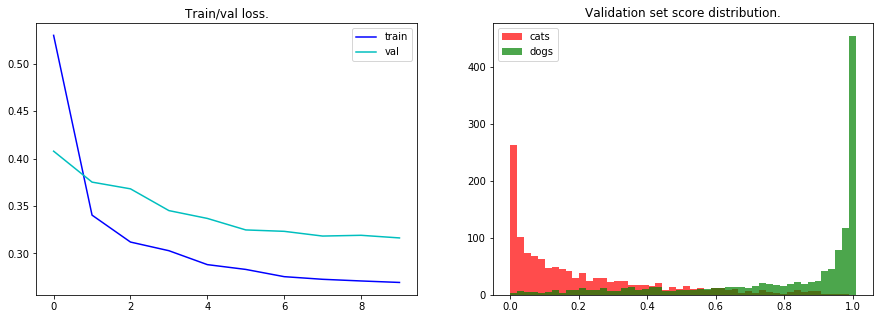

In [ ]:
# Observe that only parameters of final layer are being optimized as opposed to before
opt_resnet = torch.optim.Adam(model_resnet18.fc.parameters(), lr=1e-3)
ckpt_name_resnet18='model_resnet_18_finetune.ckpt'

runner_finetune = CNNRunner(model_resnet18, opt_resnet, device, ckpt_name_resnet18)
runner_finetune.train(train_batch_gen, val_batch_gen, n_epochs=10, visualize=True)

## Evaluation

In [ ]:
best_model_resnet18 = torch.load(open(ckpt_name_resnet18, 'rb'))

val_stats = runner_finetune.validate(val_batch_gen, best_model_resnet18, 'val')
test_stats = runner_finetune.validate(test_batch_gen, best_model_resnet18, 'test')

if val_stats['f1'] > 0.85 and test_stats['f1'] > 0.85:
    print('You have achieved the baseline for this task.')
else:
    print('Train for some more time.')

val: loss: 0.3163 | accuracy: 0.8552 | f1: 0.8528


test: loss: 0.3043 | accuracy: 0.8652 | f1: 0.8620
You have achieved the baseline for this task.


C:\Users\gagarinsname\Miniconda3\envs\py3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Flatten. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
best_model_resnet18 = best_model_resnet18.cuda()

## Use your own image

In [ ]:
from skimage.io import imread
from skimage.transform import resize

src_1_fp = r"img/example_1.png"
src_2_fp = r"img/example_2.png"

src_1 = imread(src_1_fp)
src_2 = imread(src_2_fp)

resized_1 = resize(src_1, (SIZE_H, SIZE_W), mode='reflect')
resized_2 = resize(src_2, (SIZE_H, SIZE_W), mode='reflect')

# convert to torch.Tensor
tensor_1 = torch.Tensor(np.transpose((resized_1/255 - image_mean) / image_std, [2,0,1])[np.newaxis,:,:,:]).to(device)
tensor_2 = torch.Tensor(np.transpose((resized_2/255 - image_mean) / image_std, [2,0,1])[np.newaxis,:,:,:]).to(device)

# 'cat' scores
score_1 = F.softmax(best_model_resnet18(tensor_1), 1)[0][0].detach().cpu().numpy()
score_2 = F.softmax(best_model_resnet18(tensor_2), 1)[0][0].detach().cpu().numpy()

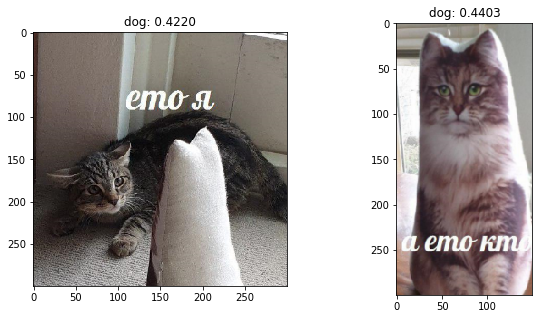

In [ ]:
get_label = lambda x: ('cat' if x > 0.5 else 'dog') + ': {:.4f}'.format(x)

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(src_1)
plt.title(get_label(score_1))
plt.subplot(122)
plt.imshow(src_2)
plt.title(get_label(score_2))
plt.show()

```
```


# Task 3: adding normalization and different model initialization
## Let's get back to hard work
* Improve the task 1 CNN architecture  with the following:
  * Add batch norm (with default params) between convolution and ReLU
    * nn.BatchNorm*d (1d for dense, 2d for conv)
    * usually better to put them after linear/conv but before nonlinearity
* Re-train the network with the same optimizer, it should get at least __80%__ validation accuracy at peak.
* Use the following model class to simplify the inference


To know more about **batch_norm** and **data covariate shift**

https://towardsdatascience.com/batch-normalization-in-neural-networks-1ac91516821c

https://www.youtube.com/watch?v=nUUqwaxLnWs

In [ ]:
# Custom model class

def conv_block_3x3(in_channels, out_channels, stride=1):
    return nn.Sequential(
        # YOUR CODE HERE
        # CONV 3x3 -> BN -> ReLU
        # YOUR CODE ENDS HERE
    )

class MyModel(torch.nn.Module):
    def __init__(self, in_feature):
        super(MyModel, self).__init__()

        self.model = nn.Sequential(
            # YOUR CODE HERE: CONV_BLOCKS->GLOBAL_POOLING (MAX/AVERAGE)
            Flatten()
        )
        self.dropout = nn.Dropout(p=0.3)
        self.fc = nn.Sequential(
            # YOUR CODE HERE: FC->BN->RELU
        )
        self.pred = nn.Sequential(
            nn.Linear(EMBEDDING_SIZE, NUM_CLASSES, bias=False)
        )

    def forward(self, x):
        x = self.model(x)
        x = self.dropout(x)
        x = self.fc(x)
        x = self.dropout(x)
        x = self.pred(x)
        return x

In [ ]:
# outputs are here for convenience
model_cnn_norm = MyModel(3)
summary(model_cnn_norm, (3, SIZE_H, SIZE_W), device='cpu')

## Training

val: loss: 0.6268 | accuracy: 0.8504 | f1: 0.8370


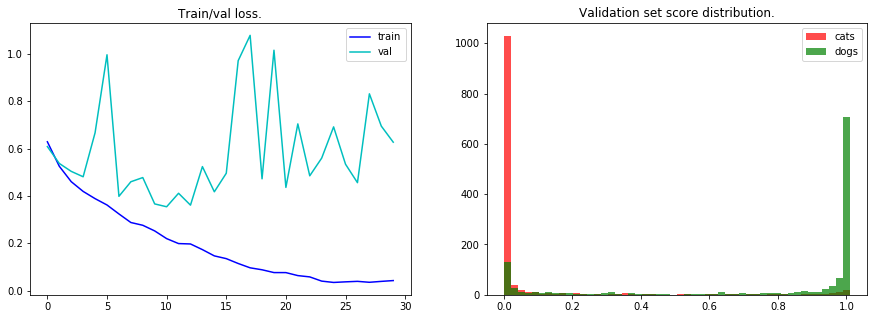

In [ ]:
model_cnn_norm = model_cnn_norm.to(device)
opt = torch.optim.Adam(model_cnn_norm.parameters(), lr=1e-3)
ckpt_name_cnn_norm='model_cnn_norm.ckpt'

runner_norm = CNNRunner(model_cnn_norm, opt, device, ckpt_name_cnn_norm)
runner_norm.train(train_batch_gen, val_batch_gen, n_epochs=EPOCH_NUM, visualize=True)

## Evaluation

In [ ]:
best_model_cnn_norm = torch.load(open(ckpt_name_cnn_norm, 'rb'))

val_stats = runner_norm.validate(val_batch_gen, best_model_cnn_norm, 'val')
test_stats = runner_norm.validate(test_batch_gen, best_model_cnn_norm, 'test')

if val_stats['f1'] > 0.83 and test_stats['f1'] > 0.83:
    print('You have achieved the baseline for this task.')
else:
    print('Train for some more time or change CNN architecture.')

val: loss: 0.6268 | accuracy: 0.8504 | f1: 0.8370


test: loss: 0.5956 | accuracy: 0.8605 | f1: 0.8482
You have achieved the baseline for this task.



```

```

```

```

```

```

```

```

```

```

```

```

```

```
# Task 4: Data Augmentation (bonus area)

There's a powerful torch tool for image preprocessing useful to do data preprocessing and augmentation.

Here's how it works: we define a pipeline that
* makes random crops of data (augmentation)
* randomly changes image color (augmentation)
* randomly flips image horizontally (augmentation)
* then normalizes it (preprocessing)

<img src="https://github.com/EvgenVer/ml_course/blob/main/week0_10_cnn/img/augmentation.png?raw=1" width="500">

In [ ]:
transformer_augmented = transforms.Compose([
    # YOUR CODE HERE
)

In [ ]:
# Load dataset using ImageFolder using transformer with augmentation
# Note: We do not use augmentation for validation or testing
train_dataset_aug = # YOUR CODE HERE: creade dataset using the transformer above
train_aug_batch_gen = torch.utils.data.DataLoader(train_dataset_aug,
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              num_workers=NUM_WORKERS)

Let's look at some image examples

In [ ]:
plot_from_batch_generator(train_aug_batch_gen)

Note that we did not change test_dataset, as we do not need to augment image data in it.

Let's retrain our model, saving it to another variable

## Training

In [ ]:
model_cnn_aug = MyModel(3).to(device)
opt = torch.optim.Adam(model_cnn_aug.parameters(), lr=1e-3)
ckpt_name_aug='model_cnn_aug.ckpt'

runner_aug = CNNRunner(model_cnn_aug, opt, device, ckpt_name_aug)
runner_aug.train(train_batch_gen, val_batch_gen, n_epochs=2 * EPOCH_NUM, visualize=True)

In [ ]:
## Evaluation

In [ ]:
best_model_cnn_aug = torch.load(open(ckpt_name_aug, 'rb'))

val_stats = runner_aug.validate(val_batch_gen, best_model_cnn_aug, 'val')
test_stats = runner_aug.validate(test_batch_gen, best_model_cnn_aug, 'test')

if val_stats['f1'] > 0.9 and test_stats['f1'] > 0.9:
    print('You have achieved the baseline for this task.')
else:
    print('Train for some more time or change augmentation scheme.')

## Dark Magic (some practical tricks and issues)

<img src="https://github.com/EvgenVer/ml_course/blob/main/week0_10_cnn/img/dm.png?raw=1" width="600">